In [1]:
# habilitate src folder to be imported from this notebook
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[0])

if module_path not in sys.path:
    sys.path.append(module_path)

___

In [2]:
import tensorflow as tf
import numpy as np
import random
from pathlib import Path

from src.loaders.dataset import DataGenerator
from src.models import (
    DenseAutoencoder,
    CNNAutoencoder,
    CNNAutoencoderBN, 
    CNNAutoencoderCAE,
    CNNAutoencoderCAEBN,
    CNNAutoencoderCAEBNLeakyRelu,
    CNNAutoencoderCAEBNL2Emb,
    )
from src.callbacks import CSVTimeHistory

In [3]:
# Params
ARCHITECTURE="CNNAutoencoderCAEBNL2Emb"
BATCH_SIZE=16
EPOCHS=30
LATENT_DIM=100

# training params
PATIENTE_EARLY_STOPPING=20
PATIENTE_LEARNING_RATE=15

# Data
list_npy = list(Path("../data/fcgr/").rglob("*.npy"))
random.shuffle(list_npy)
n_train=round(len(list_npy)*0.8)
preprocessing = lambda x: x / x.max()

In [4]:
train_generator = DataGenerator(
    list_paths=list_npy[:n_train],
    batch_size=BATCH_SIZE,
    shuffle=True,
    preprocessing=preprocessing
)

val_generator = DataGenerator(
    list_paths=list_npy[n_train:],
    batch_size=BATCH_SIZE,
    shuffle=False,
    preprocessing=preprocessing
)

In [5]:
# - Callbacks
# checkpoint: save best weights
Path("../data/train/checkpoints").mkdir(exist_ok=True, parents=True)
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    # filepath='../data/train/checkpoints/weights-{epoch:02d}-{val_loss:.3f}.hdf5',
    filepath='../data/train/checkpoints/weights.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# reduce learning rate
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=PATIENTE_LEARNING_RATE,
    verbose=1,
    min_lr=0.00001
)

# stop training if
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.001,
    patience=PATIENTE_EARLY_STOPPING,
    verbose=1
)

# save history of training
Path("../data/train").mkdir(exist_ok=True, parents=True)
cb_csvlogger = tf.keras.callbacks.CSVLogger(
    filename='../data/train/training_log.csv',
    separator=',',
    append=False
)

cb_csvtime = CSVTimeHistory(
    filename='../data/train/time_log.csv',
    separator=',',
    append=False
)

In [6]:
# training
# autoencoder=CNNAutoencoderCAEBN(LATENT_DIM)
autoencoder=eval(f"{ARCHITECTURE}(LATENT_DIM)")
autoencoder.compile(optimizer='adam', loss="binary_crossentropy")#tf.keras.losses.MeanSquaredError())
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_encoder (InputLayer)  [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496 

2022-08-30 18:06:25.947655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 18:06:25.952609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 18:06:25.952721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 18:06:25.953032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
autoencoder.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=EPOCHS,
    callbacks=[
        cb_checkpoint,
        cb_reducelr,
        cb_earlystop,
        cb_csvlogger,
        cb_csvtime
        ]
)

Epoch 1/30


2022-08-30 18:06:45.214814: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303
2022-08-30 18:06:46.132438: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-30 18:06:46.260238: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1869/1872 [============================>.] - ETA: 0s - loss: 0.1417
Epoch 1: val_loss improved from inf to 0.11856, saving model to ../data/train/checkpoints/weights.hdf5
1872/1872 [==============================] - 27s 13ms/step - loss: 0.1417 - val_loss: 0.1186 - lr: 0.0010
Epoch 2/30
1871/1872 [============================>.] - ETA: 0s - loss: 0.1179
Epoch 2: val_loss did not improve from 0.11856
1872/1872 [==============================] - 24s 13ms/step - loss: 0.1179 - val_loss: 0.1236 - lr: 0.0010
Epoch 3/30
1869/1872 [============================>.] - ETA: 0s - loss: 0.1157
Epoch 3: val_loss improved from 0.11856 to 0.11577, saving model to ../data/train/checkpoints/weights.hdf5
1872/1872 [==============================] - 24s 13ms/step - loss: 0.1157 - val_loss: 0.1158 - lr: 0.0010
Epoch 4/30
1869/1872 [============================>.] - ETA: 0s - loss: 0.1139
Epoch 4: val_loss did not improve from 0.11577
1872/1872 [==============================] - 24s 13ms/step - loss: 0.1139

___
## Visualize real vs generated FCGR

In [8]:
# extract encoder
encoder = tf.keras.models.Model(autoencoder.input,autoencoder.get_layer("output_encoder").output)
decoder = tf.keras.models.Model(autoencoder.get_layer("input_decoder").input, autoencoder.output)

# save encoder and decoder
path_save_models = Path("../data/models")
encoder.save(path_save_models.joinpath("encoder"))
decoder.save(path_save_models.joinpath("decoder"))

INFO:tensorflow:Assets written to: ../data/models/encoder/assets


INFO:tensorflow:Assets written to: ../data/models/encoder/assets


INFO:tensorflow:Assets written to: ../data/models/decoder/assets


INFO:tensorflow:Assets written to: ../data/models/decoder/assets


In [9]:
inference_data = DataGenerator(
    list_paths=list_npy[:-100],
    batch_size=10,
    shuffle=False,
    preprocessing=preprocessing,
    inference_mode=True
)

iter_inf_data = iter(inference_data)

In [10]:
# next batch
data = next(iter_inf_data)
data.shape
encoded_imgs = encoder(data).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

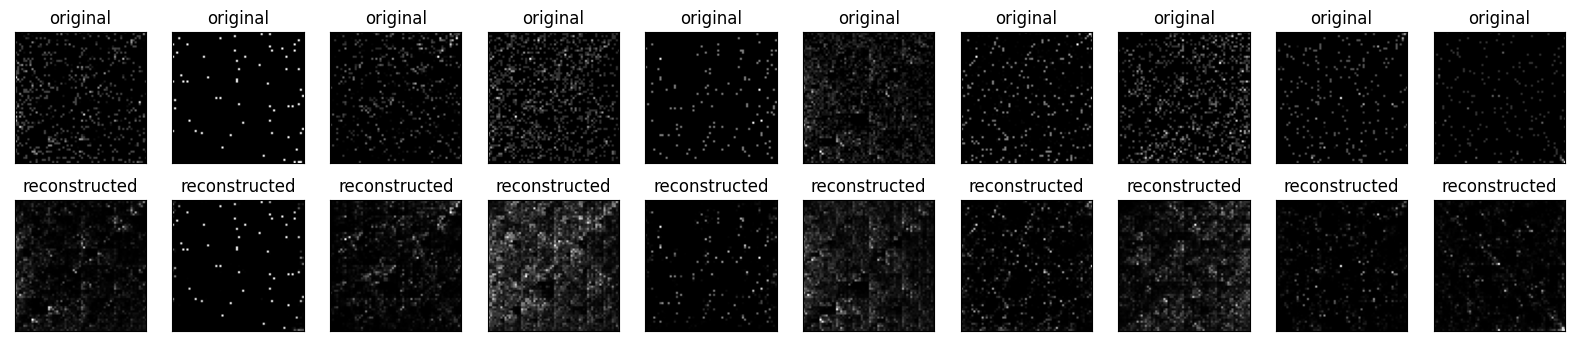

In [11]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(data[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i,:,:,0])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
decoded_imgs.shape

In [ ]:
encoded_imgs

___
# Save embeddings for FAISS

In [ ]:
all_data = DataGenerator(
    list_paths=list_npy,
    batch_size=10,
    shuffle=False,
    preprocessing=preprocessing,
    inference_mode=True
)

In [ ]:
embeddings = []

for data in iter(all_data):
    encoded_imgs = autoencoder.encoder(data).numpy()
    embeddings.append(encoded_imgs)

In [ ]:
all_emb = np.concatenate(embeddings, axis=0)
all_emb.shape

In [ ]:
import json

assert len(all_emb) == len(list_npy), "embeddings and ids does not match"

# save embeddings
path_emb = Path("../data/faiss-embeddings")
path_emb.mkdir(exist_ok=True, parents=True)
np.save(file=path_emb.joinpath("embeddings.npy"), arr=all_emb)
with open(path_emb.joinpath("id_embeddings.json"), "w") as fp:
    json.dump({j: p.stem for j,p in enumerate(list_npy)}, fp, indent=4)